<a target="_blank" href="https://colab.research.google.com/github/pozzo-research-group/papers/blob/polymer-blends/pluronic-phasemaps/visualize.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [22]:
!pip install git+https://github.com/kiranvad/warping.git

  Cloning https://github.com/kiranvad/warping.git to /tmp/pip-req-build-zj49nx5i
  Running command git clone --filter=blob:none --quiet https://github.com/kiranvad/warping.git /tmp/pip-req-build-zj49nx5i
  Resolved https://github.com/kiranvad/warping.git to commit 606c34d88d8c71584ce1f09c6e458f340e0aa0f2
  Preparing metadata (setup.py) ... done
  Created wheel for warping: filename=warping-0.0.1-cp310-cp310-linux_x86_64.whl size=169792 sha256=c8e326e7edcb2951cecfab30f500508692e50e9882ea71474a044b26ac70e1d8
  Stored in directory: /tmp/pip-ephem-wheel-cache-kgqu3ad6/wheels/f2/e1/48/a026eb89f4e56f1e94028aa2632c212015217e14ef39b74ac5
Successfully built warping


In [1]:
!pip install --quiet git+https://github.com/pozzo-research-group/autophasemap.git@add_multi_kmeans

  Preparing metadata (setup.py) ... done


In [2]:
!pip install --quiet gpytorch

In [10]:
!git clone -b polymer-blends https://github.com/pozzo-research-group/papers.git
!cd papers

Cloning into 'papers'...
remote: Enumerating objects: 1578, done.
remote: Counting objects: 100% (300/300), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 1578 (delta 130), reused 253 (delta 129), pack-reused 1278
Receiving objects: 100% (1578/1578), 450.86 MiB | 29.25 MiB/s, done.
Resolving deltas: 100% (696/696), done.
Updating files: 100% (898/898), done.


In [14]:
!cd papers/pluronic-phasemaps/

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.append("./papers/pluronic-phasemaps/")

from utils import DataSet, plot_phasemap_contours
from autophasemap import plot_clusters

### Visualizing phasemap
This code allows the user to plot a phasemap from the pre-computed results.
There are three datasets:
0. Pluronic P123 for varying temperature
1. Pluronic P123 with 1% of PPBT (a conjugated polymer) with varying temperature
2. Blends of conjugated polymer (PPBT) and Pluronic (P123)

Each dataset has a corresponding phasemap with 1 to 15 phases obtained through `autophasemap`. To visualize a phasemap select a dataset using `DATA_ID` and number of clusters using `N_CLUSTERS`.

In [24]:
filenames = ["PPBT_0_P123_Y_Temp", "PPBT_1_P123_Y_Temp", "blends_WSCP_P123_NOpH"]

DATA_ID = 0 # correspond to the index of files names in `filenames`
N_CLUSTERS = 5

In [26]:
if DATA_ID==0:
    saxs = np.load('./papers/pluronic-phasemaps/data/%s.npz'%filenames[DATA_ID])
    Iq = saxs["Iq"]
    q = saxs["q"]
    C = saxs["c"]

elif DATA_ID==1:
    Iq = np.load('./papers/pluronic-phasemaps/data/PPBT_1_P123_Y_Temp.npz')["Iq"]
    q = np.load('./papers/pluronic-phasemaps/data/PPBT_0_P123_Y_Temp.npz')["q"]
    C = np.load('./papers/pluronic-phasemaps/data/PPBT_0_P123_Y_Temp.npz')["c"]

elif DATA_ID==2:
    saxs = np.load('./papers/pluronic-phasemaps/data/%s.npz'%filenames[DATA_ID])
    Iq = saxs["Iq"]
    q = saxs["q"]
    C = saxs["C"]

with open('./papers/pluronic-phasemaps/results/%s/result_%d.pkl'%(filenames[DATA_ID], N_CLUSTERS), 'rb') as f:
    result = pickle.load(f)

n_domain = len(q)
if not DATA_ID==2:
    temp_flags = C[:,1]<85
    C = C[temp_flags,:]
    Iq = Iq[temp_flags,:]
    n_domain = len(result["templates"][0])

data = DataSet(C, q, Iq, n_domain)
data.generate(apply_spine=True)

### Plot phasemap using contour plots

In simple terms, the following computes probability of any point in the composition belonging to a particular phase region using a class of Gaussian Processes (GP) called Dirichlet GP as descrined [in this tutorial](https://docs.gpytorch.ai/en/stable/examples/01_Exact_GPs/GP_Regression_on_Classification_Labels.html).

We first fit a GP based on the phase labels obtained and use it to predict probabilities on a grid samples (`n_grid_points X n_grid_points`) of which we assign a contour color for all the points below a `min_prob` probability of a particular phase.

Iter 1/200 - Loss: 23.250   lengthscale: 0.693   noise: 0.693
Iter 51/200 - Loss: 9.748   lengthscale: 3.836   noise: 0.717
Iter 101/200 - Loss: 9.134   lengthscale: 4.792   noise: 0.087
Iter 151/200 - Loss: 9.035   lengthscale: 5.139   noise: 0.036


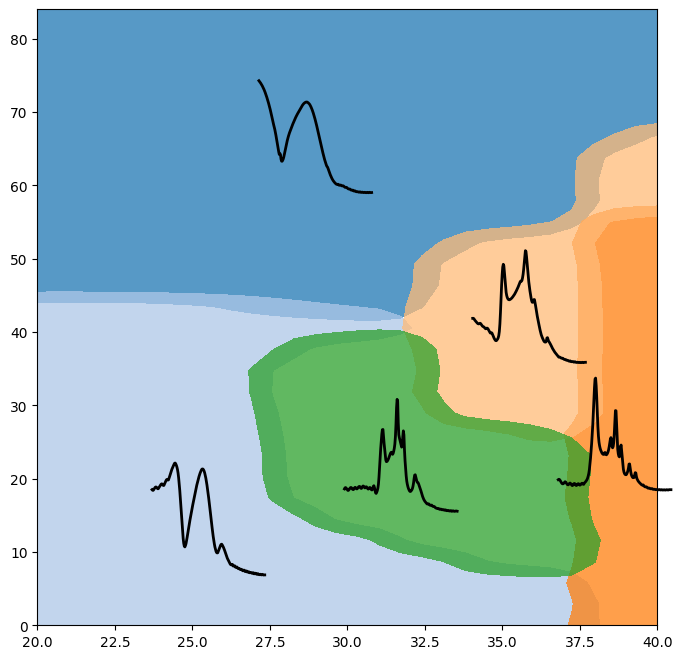

In [27]:
plot_phasemap_contours(data,
                       result,
                       min_prob=0.3, # defines minimum probability of any phase
                       n_grid_points=30 # defines number of grid points to evaluate probabilities
                       )

### Plot data associated with each phase region identified

The following can be used to plot learned template (in corresponding color from above) and the assigned measured SAXS data in gray color to obtain some understanding of nature of assignment and within phase variation

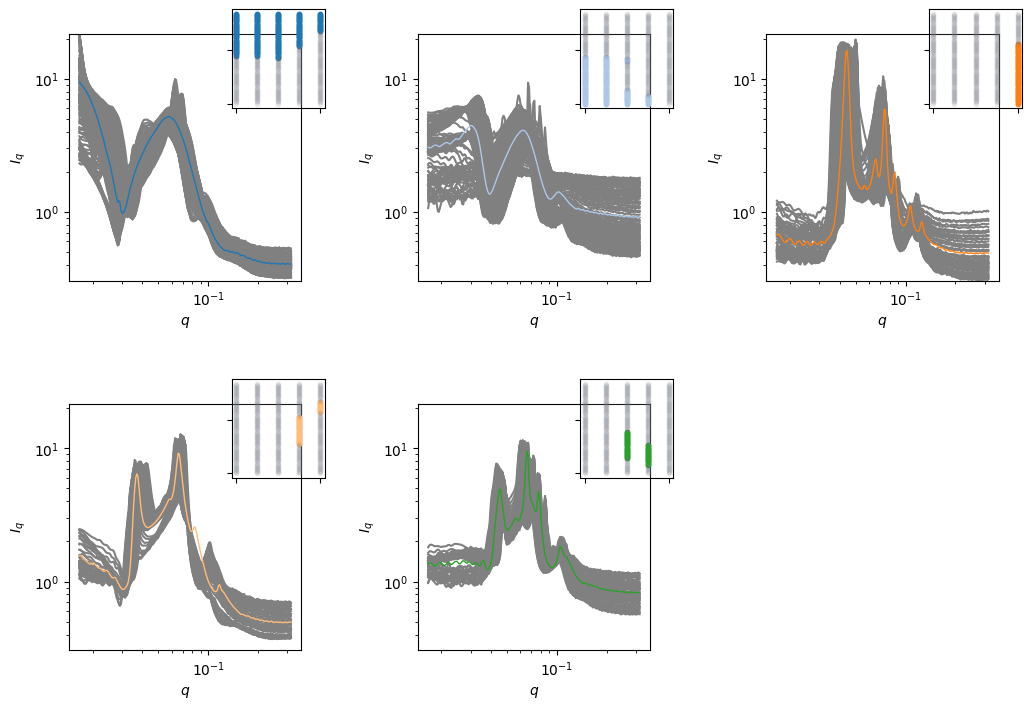

In [28]:
nrows, ncols = 2, 3 # change these values accordinto how many panels you need
fig, axs = plt.subplots(nrows, ncols, figsize = (4*ncols, 4*nrows))
axs = axs.flatten()
[ax.remove() for ax in axs[N_CLUSTERS:]]
fig.subplots_adjust(wspace=0.5, hspace=0.5)
plot_clusters(axs, data, result, mode="input")
plt.show()